<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v2/Conv_VAE_Novel_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
tf.autograph.set_verbosity(0)
from google.colab import drive
drive.mount('/content/drive/')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#### Import Data and plot it

In [0]:
def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

#### Select data, pre-process it and create dataset

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

def make_categorical(y):
    y_cat = tf.keras.utils.to_categorical(y)
    return y_cat

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(len(train_images)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(len(test_images)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

def setup_dataset_no_shuffle(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled    

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_mean = tf.math.sigmoid(pixel_output)
        return pixel_mean

#### Define the loss function 

In [0]:
def calculate_KL(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    return KL

def calculate_logpx_z(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    return logpx_z

def calculate_ELBO(model, x):
    logpx_z = calculate_logpx_z(model, x)
    KL = calculate_KL(model, x)
    
    ELBO = logpx_z - KL 
    return -ELBO #Negative because we want to maximise it

In [0]:
def calculate_logpx_z_mean(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    return logpx_z

def calculate_pixel_squared(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    pixel_squared = np.square(pixel_prob - x)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    pixel_squared = tf.reduce_mean (pixel_squared)
    return pixel_squared

def calculate_pixel_squared_mean(model, x):
    z_mean, z_logvar = model.encode(x)
    pixel_prob = model.decode(z_mean)
    pixel_squared = np.square(pixel_prob - x)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    pixel_squared = tf.reduce_mean (pixel_squared)
    return pixel_squared

In [0]:
def calculate_ssim(model, x):
  z_mean, z_logvar = model.encode(x)
  z = model.reparameterize(z_mean, z_logvar)
  y = model.decode(z)

  x = tf.convert_to_tensor(x)
  y = tf.convert_to_tensor(y)
  ssim = tf.image.ssim(x[:,:,:,:],y[:,:,:,:], input_range, filter_size=11,filter_sigma=0.1,k1=0.1,k2=0.01)
  ssim = tf.reduce_mean(ssim)
  return (1-ssim)*1000

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train the data

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        x_class, y_class = pick_class(x, y, [chosen_classes[i]])
        x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

In [14]:
mnist = tf.keras.datasets.mnist
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

4423680/4422102 [==============================] - 0s 0us/step


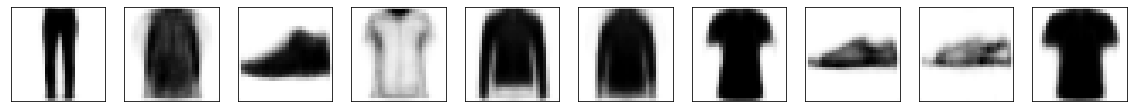

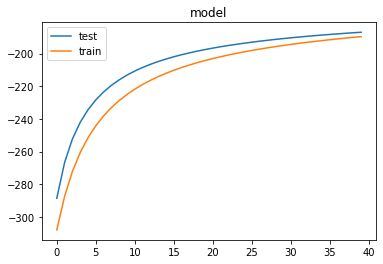

In [19]:
x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7])

z_size = 2
model_nov = CVAE(z_size)

train_test_dataset(model_nov, train_dataset_0, test_dataset_0, 40, generate=True)

In [0]:
#model_nov.encoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_novel_model/Encoder_25/Encoder.npy')
#model_nov.decoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_novel_model/Decoder_25/Decoder.npy')
#model_nov.encoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_novel_model/Encoder_10/Encoder.npy')
#model_nov.decoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_novel_model/Decoder_10/Decoder.npy')
#model_nov.encoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_novel_model/Encoder_2/Encoder.npy')
#model_nov.decoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_novel_model/Decoder_2/Decoder.npy')

In [15]:
model_nov_25 = CVAE(25)
model_nov_25.encoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_novel_model/Encoder_25/Encoder.npy')
model_nov_25.decoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_novel_model/Decoder_25/Decoder.npy')
model_nov_10 = CVAE(10)
model_nov_10.encoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_novel_model/Encoder_10/Encoder.npy')
model_nov_10.decoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_novel_model/Decoder_10/Decoder.npy')
model_nov_2 = CVAE(2)
model_nov_2.encoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_novel_model/Encoder_2/Encoder.npy')
model_nov_2.decoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_novel_model/Decoder_2/Decoder.npy')

#### Reconstruct images

Original Pictures:


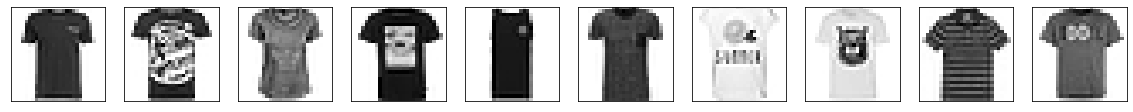

Reconstructed Pictures, with ELBO loss:


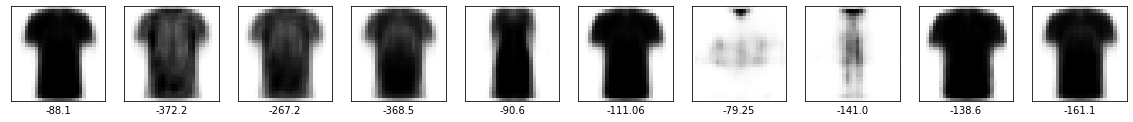

In [26]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images/input_range
    x[x >= 0.5] = 1.0
    x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model_nov_2, x_test[50:60])

#### Visualize the latent space

0 Outliers detected


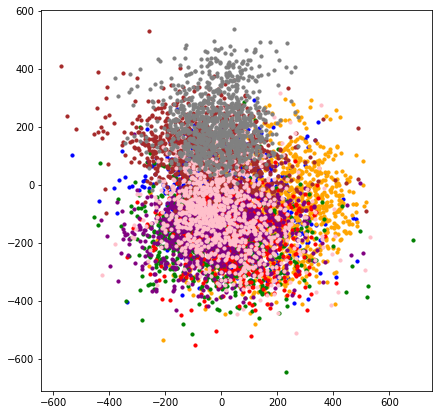

In [0]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  outlier = []
  latent_space = np.zeros([2, range2-range1, 25])
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    latent_space[0,i,:] = z_mean
    latent_space[1,i,:] = z_logvar
    
    if any(z_logvar[:,i]>10 for i in range(model.z_size)):
      outliers +=1
      outlier.append(i)
      continue

    color_dict = dict([(0,'blue'), (1,'orange'), (2,'green'), (3,'red'), (4,'purple'), (5,'brown'), (6,'pink'), (7,'gray'), (8,'black'), (9,'yellow')])
    plt.scatter(z[:,a],z[:,b], color = color_dict[data_y[i]], s=10)

  print('{} Outliers detected'.format(outliers))
  return latent_space, outlier

latent_space, outlier = visualize_latent_space(model_nov_25, 0, len(x_test_0), x_test_0, y_test_0, 0,1)

In [0]:
print(np.shape(latent_space))
np.save('/content/drive/My Drive/4YP/latent_space_nov.npy',latent_space)

#### Check reconstruction performance for untrained classes and create table of losses


In [0]:
table_of_losses = np.zeros([N_class, 5])
for i in range(1):
  model = model_nov_10
  #print('Model trained with class {}'.format(i))
  plt.figure(1, figsize=[9,4])
  plt.figure(2, figsize=[9,4])
  plt.figure(3, figsize=[9,4])
  plt.figure(4, figsize=[9,4])
  plt.figure(5, figsize=[9,4])
  for j in range(N_class):
    test_images = x_train[(y_train==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    ELBO_loss = calculate_ELBO(model, test_images)
    logpx_z_loss = calculate_logpx_z_mean(model, test_images)
    KL_loss = calculate_KL(model, test_images)
    pixel_squared_loss = calculate_pixel_squared(model,test_images)
    #print(pixel_squared_loss)
    #ssim_loss = calculate_ssim(model, test_images)
    #ssim_loss = np.mean(ssim_loss)
    #print(ssim_loss)
    table_of_losses[j,0] = ELBO_loss
    table_of_losses[j,1] = -logpx_z_loss
    table_of_losses[j,2] = KL_loss
    table_of_losses[j,3] = pixel_squared_loss
    #table_of_losses[j,4] = ssim_loss
    if j==8 or j==9:
      color='red'
    else:
      color='blue'
    plt.figure(1)
    plt.bar(j,ELBO_loss.numpy(),color=color)
    plt.figure(2)
    plt.bar(j,-logpx_z_loss.numpy(),color=color)
    plt.figure(3)
    plt.bar(j,KL_loss.numpy(),color=color)
    plt.figure(4)
    plt.bar(j,pixel_squared_loss.numpy(),color=color)
    #plt.figure(5)
    #plt.bar(j,ssim_loss.numpy(),color=color)

#for i in range(N_class):
#    table_of_losses[i,:] = table_of_losses[i,:]/np.min(table_of_losses[i,:])
 
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(np.transpose(table_of_losses), decimals=2), index=['ELBO', 'Recon_likelihood', 'KL_divergence', 'Recon_error', 'SSIM'])
table_loss


### Predict Novelties with threshold

##### Calculate novelty scores

In [0]:
x_train_full, y_train_full, x_test_full, y_test_full, train_dataset_full, test_dataset_full = setup_dataset_no_shuffle(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9])
x_train_nov, y_train_nov, x_test_nov, y_test_nov, train_dataset_nov, test_dataset_nov = setup_dataset_no_shuffle(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7])

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_squared = np.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z_images)
  return losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = Loss_4(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_12(model, x):
  losses_per_image = Loss_5(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_13(model, x):
  losses_per_image = Loss_6(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_vectors)
  return losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

In [0]:
start_time = time.time()
losses_1_test = Loss_1(model_nov_25, test_dataset_full)
end_time_1 = time.time()-start_time
print('Loss_1')

start_time = time.time()
losses_2_test = Loss_2(model_nov_25, test_dataset_full)
end_time_2 = time.time()-start_time
print('Loss_2')

start_time = time.time()
losses_3_test = Loss_3(model_nov_25, test_dataset_full)
end_time_3 = time.time()-start_time
print('Loss_3')

start_time = time.time()
losses_4_test = Loss_4(model_nov_25, test_dataset_full)
end_time_4 = time.time()-start_time
print('Loss_4')

start_time = time.time()
losses_5_test = Loss_5(model_nov_25, test_dataset_full)
end_time_5 = time.time()-start_time
print('Loss_5')

start_time = time.time()
losses_6_test = Loss_6(model_nov_25, test_dataset_full)
end_time_6 = time.time()-start_time
print('Loss_6')

start_time = time.time()
losses_7_test = Loss_7(model_nov_25, train_dataset_nov, test_dataset_full)
end_time_7 = time.time()-start_time
print('Loss_7')

start_time = time.time()
losses_8_test = Loss_8(model_nov_25, train_dataset_nov, test_dataset_full)
end_time_8 = time.time()-start_time
print('Loss_8')

start_time = time.time()
losses_9_test = Loss_9(model_nov_25, train_dataset_nov, test_dataset_full)
end_time_9 = time.time()-start_time
print('Loss_9')

start_time = time.time()
losses_10_test = Loss_10(model_nov_25, train_dataset_nov, test_dataset_full)
end_time_10 = time.time()-start_time
print('Loss_10')

start_time = time.time()
losses_11_test = Loss_11(model_nov_25, test_dataset_full)
end_time_11 = time.time()-start_time
print('Loss_11')

start_time = time.time()
losses_12_test = Loss_12(model_nov_25, test_dataset_full)
end_time_12 = time.time()-start_time
print('Loss_12')

start_time = time.time()
losses_13_test = Loss_13(model_nov_25, test_dataset_full)
end_time_13 = time.time()-start_time
print('Loss_13')

start_time = time.time()
losses_14_test = Loss_14(model_nov_25, test_dataset_full)
end_time_14 = time.time()-start_time
print('Loss_14')

start_time = time.time()
losses_15_test = Loss_15(model_nov_25, train_dataset_nov, test_dataset_full)
end_time_15 = time.time()-start_time
print('Loss_15')

start_time = time.time()
losses_16_test = Loss_16(model_nov_25, train_dataset_nov, test_dataset_full)
end_time_16 = time.time()-start_time
print('Loss_16')

start_time = time.time()
losses_17_test = Loss_17(model_nov_25, train_dataset_nov, test_dataset_full)
end_time_17 = time.time()-start_time
print('Loss_17')

In [0]:
print('Loss_1; Time elapsed: {}'.format(end_time_1))
print(losses_1_test[0:20])

print('Loss_2; Time elapsed: {}'.format(end_time_2))
print(losses_2_test[0:20])

print('Loss_3; Time elapsed: {}'.format(end_time_3))
print(losses_3_test[0:20])

print('Loss_4; Time elapsed: {}'.format(end_time_4))
print(losses_4_test[0:20])

print('Loss_5; Time elapsed: {}'.format(end_time_5))
print(losses_5_test[0:20])

print('Loss_6; Time elapsed: {}'.format(end_time_6))
print(losses_6_test[0:20])

print('Loss_7; Time elapsed: {}'.format(end_time_7))
print(losses_7_test[0:20])

print('Loss_8; Time elapsed: {}'.format(end_time_8))
print(losses_8_test[0:20])

print('Loss_9; Time elapsed: {}'.format(end_time_9))
print(losses_9_test[0:20])

print('Loss_10; Time elapsed: {}'.format(end_time_10))
print(losses_10_test[0:20])

print('Loss_11; Time elapsed: {}'.format(end_time_11))
print(losses_11_test[0:20])

print('Loss_12; Time elapsed: {}'.format(end_time_12))
print(losses_12_test[0:20])

print('Loss_13; Time elapsed: {}'.format(end_time_13))
print(losses_13_test[0:20])

print('Loss_14; Time elapsed: {}'.format(end_time_14))
print(losses_14_test[0:20])

print('Loss_15; Time elapsed: {}'.format(end_time_15))
print(losses_15_test[0:20])

print('Loss_16; Time elapsed: {}'.format(end_time_16))
print(losses_16_test[0:20])

print('Loss_17; Time elapsed: {}'.format(end_time_17))
print(losses_17_test[0:20])

In [0]:
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_1_test.npy',losses_1_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_2_test.npy',losses_2_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_3_test.npy',losses_3_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_4_test.npy',losses_4_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_6_test.npy',losses_6_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_5_test.npy',losses_5_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_7_test.npy',losses_7_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_8_test.npy',losses_8_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_9_test.npy',losses_9_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_10_test.npy',losses_10_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_11_test.npy',losses_11_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_12_test.npy',losses_12_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_13_test.npy',losses_13_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_14_test.npy',losses_14_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_15_test.npy',losses_15_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_16_test.npy',losses_16_test)
#np.save('/content/drive/My Drive/4YP/Novelty_Losses/losses_17_test.npy',losses_17_test)

losses_1_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_1_test.npy')
losses_2_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_2_test.npy')
losses_3_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_3_test.npy')
losses_4_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_4_test.npy')
losses_5_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_5_test.npy')
losses_6_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_6_test.npy')
losses_7_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_7_test.npy')
losses_8_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_8_test.npy')
losses_9_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_9_test.npy')
losses_10_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_10_test.npy')
losses_11_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_11_test.npy')
losses_12_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_12_test.npy')
losses_13_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_13_test.npy')
losses_14_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_14_test.npy')
losses_15_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_15_test.npy')
losses_16_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_16_test.npy')
losses_17_test = np.load('/content/drive/My Drive/4YP/Novelty_Losses/losses_17_test.npy')

losses_dict = dict([(1,losses_1_test),(2,losses_2_test),(3,losses_3_test),(4,losses_4_test),(5,losses_5_test),(6,losses_6_test),
                    (7,losses_7_test),(8,losses_8_test),(9,losses_9_test),(10,losses_10_test),(11,losses_11_test),(12,losses_12_test),
                    (13,losses_13_test),(14,losses_14_test),(15,losses_15_test),(16,losses_16_test),(17,losses_17_test)])

#### Predict novelties

In [0]:
y_true = np.zeros([len(y_test_full),])
unnovel_idx = np.where(y_test_full < 8)
novel_idx = np.where(y_test_full >= 8)
y_true[unnovel_idx] = 0
y_true[novel_idx] = 1

def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]
  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.show()
  return optimal_threshold, roc_auc

threshold_dict = dict([])
auc_dict = dict([])
for i in range(1,18):
  threshold_dict[i], auc_dict[i] = threshold_ROC(y_true, losses_dict[i], 'Loss_'+str(i), plot=False)

In [86]:
def check_results(y, losses, threshold):
  novelty_y = np.zeros([len(y),])
  novelty_y[np.where(y >= 8)] = 1
  novelty_prediction = np.zeros([len(y),])
  novelty_prediction[np.where(losses>threshold)] = 1

  table_of_counts = np.zeros([2,2])
  for i in range(len(y),):
    if novelty_y[i] == 0:
      if novelty_prediction[i] == 0:
        table_of_counts[0,0] += 1
      else: table_of_counts[0,1] += 1
    if novelty_y[i] == 1:
      if novelty_prediction[i] == 0:
        table_of_counts[1,0] += 1
      else: table_of_counts[1,1] += 1

  true_positive = table_of_counts[1,1]
  false_positive = table_of_counts[0,1]
  true_negative = table_of_counts[0,0]
  false_negative = table_of_counts[1,0]

  accuracy = (true_positive+true_negative)/len(y)
  avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

  return table_of_counts, accuracy, avg_accuracy

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])
for i in range(1,18):
  table_of_counts_dict[i], accuracy_dict[i], avg_accuracy_dict[i] = check_results(y_test_full, losses_dict[i], threshold_dict[i])

result_table = np.empty([17,3])
index = ['_']*17
for i in range(17):
  result_table[i,0] = accuracy_dict[i+1]*100
  result_table[i,1] = "{0:.2f}".format(avg_accuracy_dict[i+1]*100)
  result_table[i,2] = "{0:.2f}".format(auc_dict[i+1]*100)
  index[i] = 'Loss_'+str(i+1)

pd.DataFrame(result_table, index=index, columns=['Accuracy', 'Average_accuracy', 'AUC'])

,Accuracy,Average_accuracy,AUC
Loss_1,66.52,70.08,75.42
Loss_2,66.17,69.71,75.08
Loss_3,65.09,68.94,73.88
Loss_4,65.86,71.33,76.46
Loss_5,66.09,70.72,76.34
Loss_6,65.18,69.73,75.07
Loss_7,73.77,74.55,81.98
Loss_8,71.17,73.21,78.30
Loss_9,71.69,73.81,79.78
Loss_10,69.93,69.96,74.09


### Predict Novelties with NN

#### Calculate novelty images

In [0]:
x_train_full, y_train_full, x_test_full, y_test_full, train_dataset_full, test_dataset_full = setup_dataset_no_shuffle(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9])
x_train_nov, y_train_nov, x_test_nov, y_test_nov, train_dataset_nov, test_dataset_nov = setup_dataset_no_shuffle(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7])

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_squared = np.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z_images)
  return losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = Loss_4(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_12(model, x):
  losses_per_image = Loss_5(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_13(model, x):
  losses_per_image = Loss_6(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_vectors)
  return losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image